# Training

I have tried to train the models as closely as they appear in the papers or articles, so I can see that my metrics are correct. I simplified the task a bit and trained the model on 256x256 crops. The pre-trained DilatedResNet50 on ImageNet was taken as the starting point, which is Fully Convolutional Network.

The network was optimized using the SGD optimizer with the parameters that were presented in the original article of the ADE20k dataset.
I followed the recommendation from the article, using CosineAnnealingLR, the learning rate starts from high values and goes to zero towards the end of the training and increases the learning rate according on the batch size scale. 

I run three experiments
1) Training model with vanilla convolutions. This is the baseline model for comparison.
2) Training model with the last three conv 3x3 layers replaced with deformable convolutions (v1).
3) Training model with the last three conv 3x3 layers replaced with modulated deformable convolutions (v2).

The models were trained on 4xV100 GPUs with a batch size of 112 for 20 epochs and took about 3-4h each. 

## Difficulties of the training

- I poorly estimated the scale of the task. I did not know how much time and memory it takes to train the network. Started with Tesla T4 with 16Gb, then RTX 3090 with 24Gb, but ended up with 4xV100 with 32Gb.
- It is not always clear from the paper how exactly the model was trained.
- I was afraid that my network would overfit and wanted to achieve the same metrics on the train and validation. I always thought that maybe I need to change some hyper-parameter and everything will get better, but in the end I decided to fix the hyper-parameters, as in the papers.
- On the first experiments with deformable convolution, I got that they work a slightly worse, but it was my mistake in the code. I forgot to copy the pretrained convolution weights into the deformable convolutions, so they were initialized randomly. It is worth noting that a network with deformable convolutions must perform as a network with regular convolutions, because the offsets values are initially zero.
- I found that the ShiftScaleRotate mask_value argument was not set correctly and added some class instead of the unlabeled class.

## Training code

In [1]:
import datetime
import random
from pathlib import Path

import lightning.pytorch as pl
import torch
from lightning.pytorch.callbacks import (
    LearningRateMonitor,
    ModelCheckpoint,
    TQDMProgressBar,
)
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import Dataset

from src.dataset import ADE20KDataset, get_transforms
from src.models import ConvNet, SegmentationModel
from src.visualization import show_example

In [2]:
# We have set a fixed seed, these settings have been shown to work great.
pl.seed_everything(42, workers=True)
torch.set_float32_matmul_precision("medium")
# wandb.login(key=<key>)
dataset_path = Path("dataset/ADEChallengeData2016")

Global seed set to 42


### Config

I runned experiments with this config, the only change is `use_deform_convs` for three different values: `None`, `v1` and `v2`.

In [3]:
# Batch size and Learning rate scaling rule, see https://arxiv.org/abs/1706.02677
bs_lr_scale = 7
config = {
    "gpus": [0, 1, 2, 3],
    "epochs": 30,
    "batch_size": 16 * bs_lr_scale,
    "num_workers": 8,
    "dropout": 0.1,
    # Optimizer parameters taken from the paper.
    "optimizer_params": {
        "lr": 0.02 * bs_lr_scale,
        "betas": 0.9,
        "weight_decay": 1e-4,
    },
    "use_deform_convs": "v2",  # None, "v1" or "v2"
    # We simplify the task and train our model on smaller crops.
    "img_size": 256,
    "n_classes": 150,
    # These are RGB mean+std values across a large photo dataset.
    "mean": [0.485, 0.456, 0.406],
    "std": [0.229, 0.224, 0.225],
}
# From original paper:
# Trained for 100k iters, with batch size 2 on 8 GPUs, which is 1.600k image iterations with full resolution images approx ~80 epochs.
# Due to the simplification of the task, I reduce the number of iterations by a factor of 4, which is approximately ~20 epochs.
task_complexity_reduction = 4
config["max_steps"] = int(
    (1_600_000 / task_complexity_reduction) / config["batch_size"] / len(config["gpus"])
)

### Dataset and DataLoader

In [4]:
train_ds = ADE20KDataset(
    images_path=dataset_path / "images/training",
    annotation_path=dataset_path / "annotations/training",
    transforms=get_transforms(
        mean=config["mean"],
        std=config["std"],
        fixed_img_size=config["img_size"],
        # We use augmentations for train dataset.
        use_augmentations=True,
    ),
)
valid_ds = ADE20KDataset(
    images_path=dataset_path / "images/validation",
    annotation_path=dataset_path / "annotations/validation",
    transforms=get_transforms(
        mean=config["mean"],
        std=config["std"],
        # We will also evaluate on crops.
        fixed_img_size=config["img_size"],
    ),
)

("Train", len(train_ds)), ("Valid", len(valid_ds))

(('Train', 20210), ('Valid', 2000))

#### Some train examples

We swap the image channels from BGR to RGB and change the grayscale annotations to RGB.

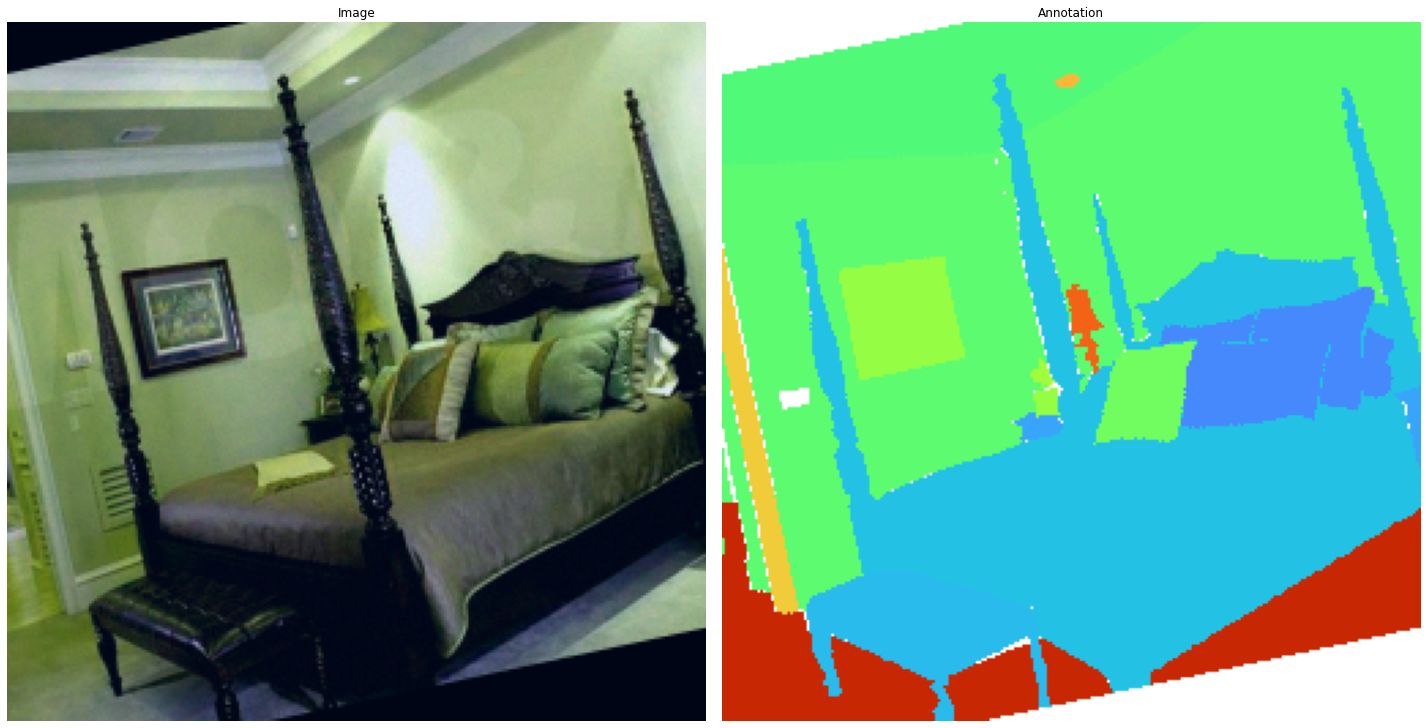

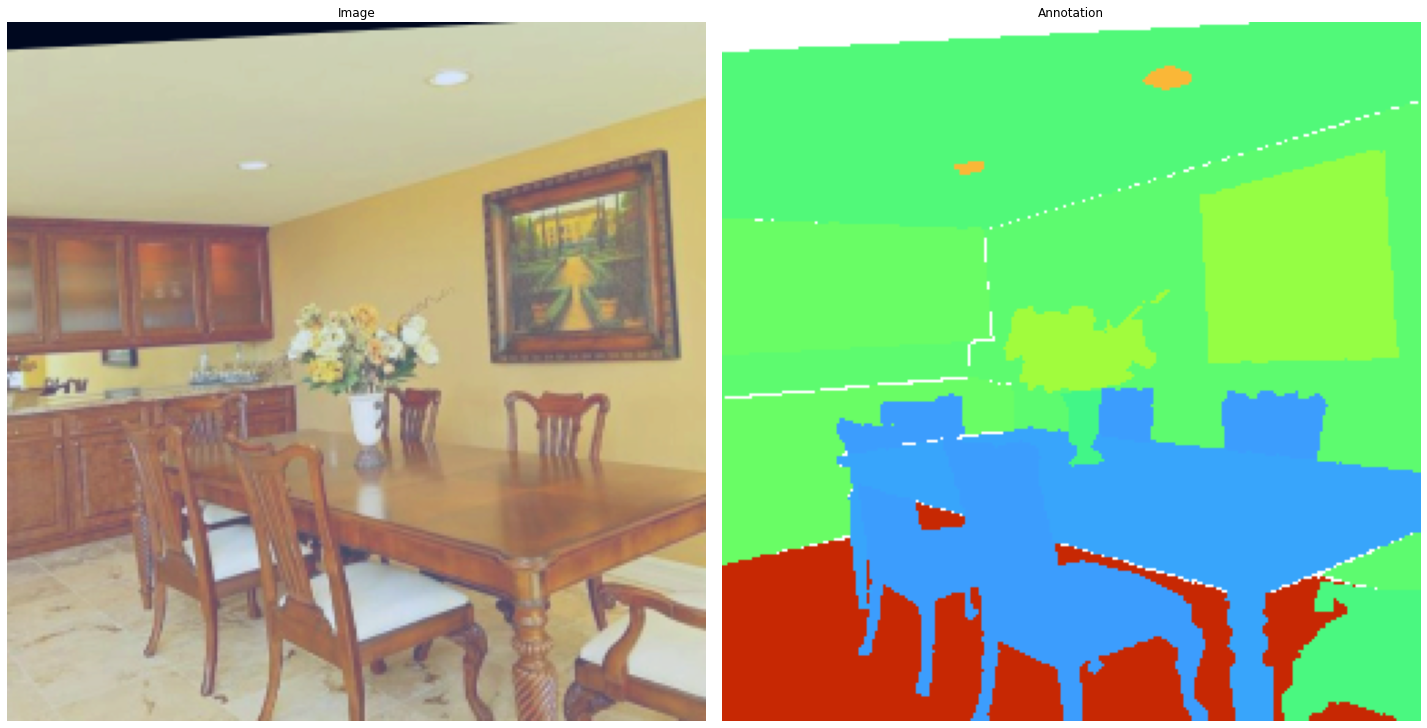

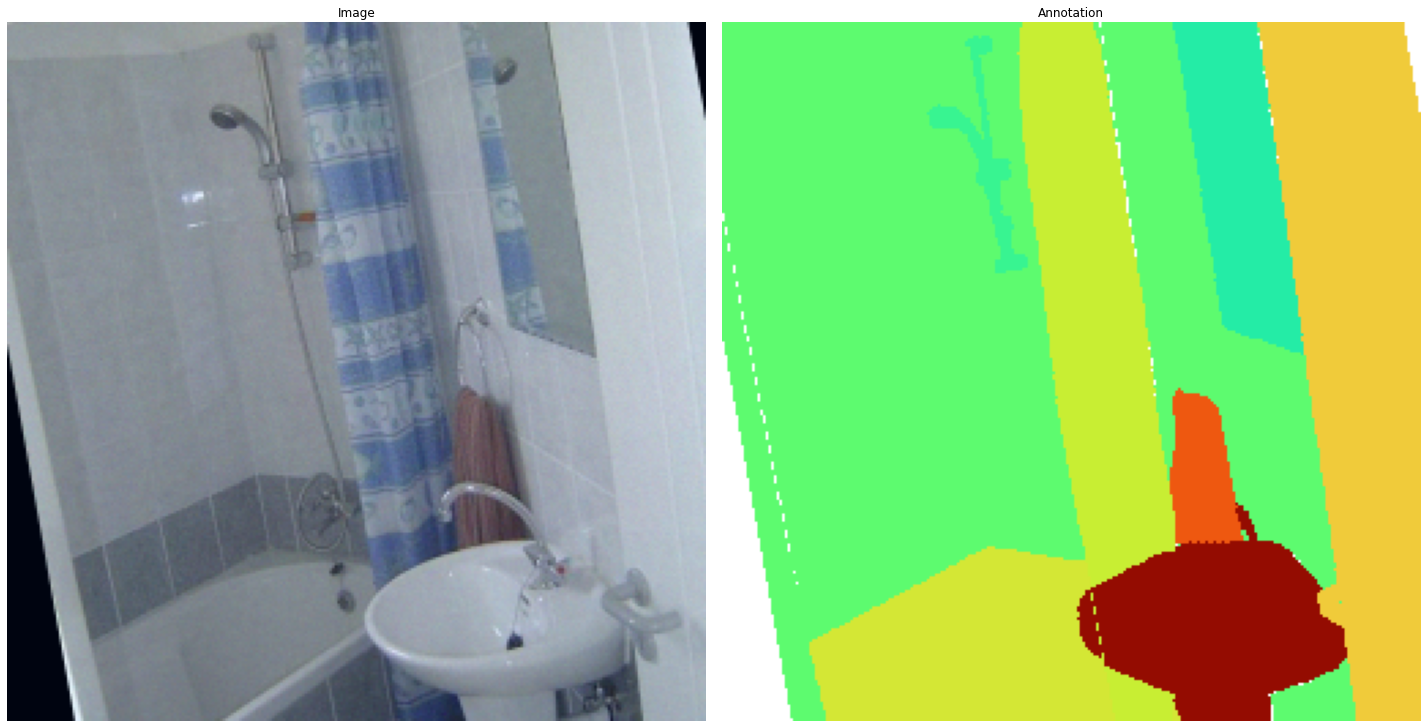

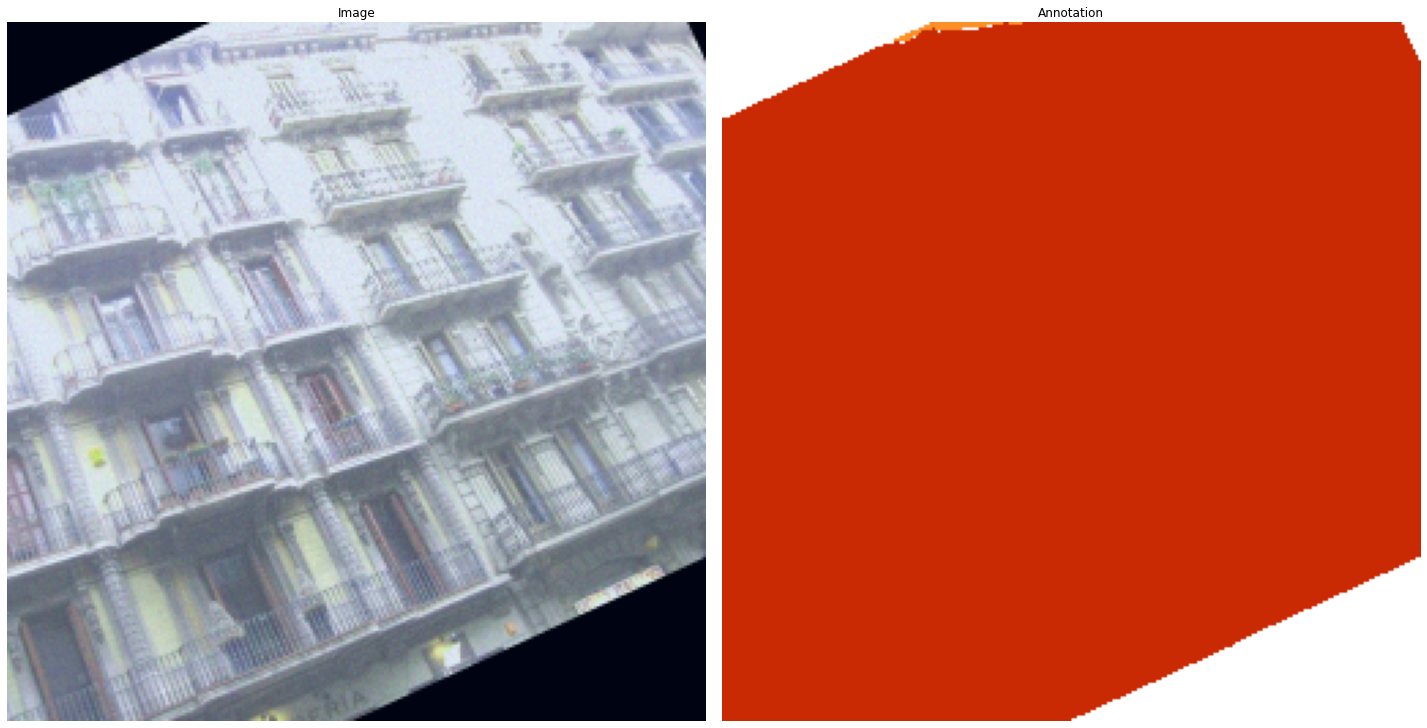

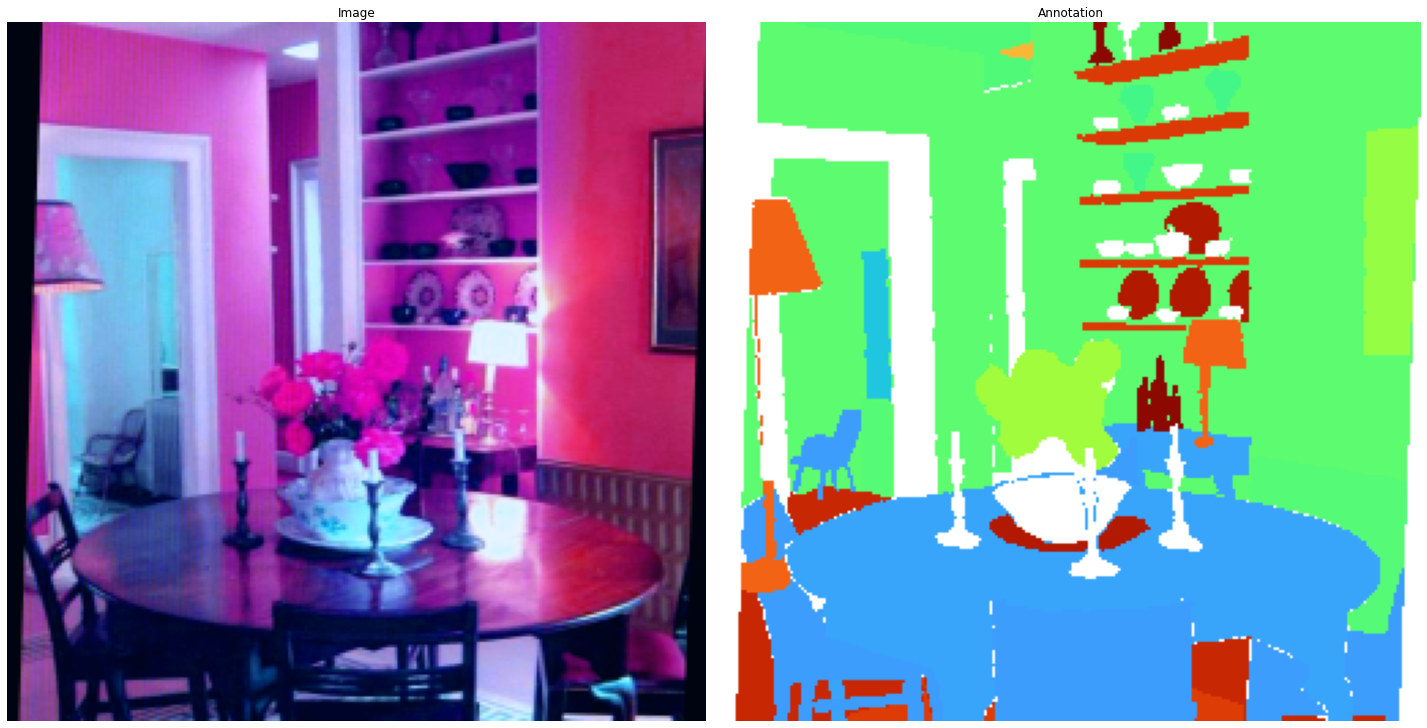

In [5]:
for _ in range(5):
    sample, labeled_img = random.choice(train_ds)
    show_example(sample.permute(1, 2, 0), (labeled_img + 1).unsqueeze(-1).repeat(1, 1, 3))

In [5]:
train_dataloaders = torch.utils.data.DataLoader(
    train_ds,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=config["num_workers"],
    pin_memory=True,
    drop_last=True,
)
val_dataloaders = torch.utils.data.DataLoader(
    valid_ds,
    batch_size=config["batch_size"],
    shuffle=False,
    num_workers=config["num_workers"],
    pin_memory=True,
    drop_last=True,
)

### Trainer

Next cell will run the training process.

I decided to use the PyTorch Lighting library instead of writing a training loop myself.

All the models were trained on the server without a Jupyter Notebook, but put it in a notebook for the presentation.

In [ ]:
# Init the Segmentation model
lighting_model = SegmentationModel(
    model=ConvNet(
        num_class=config["n_classes"],
        dropout=config["dropout"],
        use_deform_convs=config["use_deform_convs"],
    ),
    loss_func=torch.nn.CrossEntropyLoss(ignore_index=-1),  # -1 is non-labeled class
    config=config,
)

# Define Trainer
root_dir = f"artifacts/{datetime.datetime.now()}"
log_freq = max(10, 800 // config["batch_size"])
trainer = pl.Trainer(
    default_root_dir=root_dir,
    # I used max_steps, which is equal to setting max_epochs to 20.
    max_steps=config["max_steps"],
    accelerator="cuda",
    # I used here AMP, which allows to reduce GPU memory consumption without losing accuracy.
    precision="16-mixed",
    # Training with multiple GPUs in notebook is possible, but I recommend to copy code and run as python script.
    # # strategy="ddp_notebook",
    devices=config["gpus"],
    callbacks=[
        TQDMProgressBar(refresh_rate=log_freq),
        ModelCheckpoint(
            dirpath=root_dir,
            monitor="validation/IoU",
            mode="max",
            save_last=True,
            save_top_k=3,
        ),
        # I tried using the LearningRateFinder, and it shows values similar to the predefined LR=0.02.
        # # LearningRateFinder(),
        # I decided not to use EarlyStopping, to keep experiments more consistent.
        # # EarlyStopping(monitor="validation/loss", min_delta=0.001, patience=5, mode="min"),
        LearningRateMonitor(logging_interval="step"),
    ],
    logger=WandbLogger(project="pa228-project", save_dir=root_dir, config=config),
    log_every_n_steps=log_freq,
)

# Validating the model before training.
trainer.validate(lighting_model, dataloaders=val_dataloaders)
trainer.fit(
    lighting_model,
    train_dataloaders=train_dataloaders,
    val_dataloaders=val_dataloaders,
)
# Validating the model after training.
trainer.validate(lighting_model, dataloaders=val_dataloaders)

In [41]:
ls models

resnet50-conv/     resnet50-def-conv-v1/     resnet50-def-conv-v2/
resnet50-conv.zip  resnet50-def-conv-v1.zip  resnet50-def-conv-v2.zip


# Evaluation

One note, that we evaluate models on crops, which means its not correct to compare recieved metrics with papers results, but these metric is helpfull to comparing our experiments.

All the metrics/logs/configs are available on public WANDB project: https://wandb.ai/tesskyrim000/pa228-project

There are a lot of different runs, but we are interested in finals runs: `conv-149`, `def-conv-v1-157` and `def-conv-v2-156`.

## Summary 

Based on the results of the experiment, the following conclusions can be drawn:
- Deformable Convolutions give +0.8% mIoU on validation, and perform better than regular Convolutions. Modulation mechanism further improves the result, and gives additional +0.5% mIoU on validation.
- Deformable convolution adds very few parameters and slightly slows down learning.
- The experiments were carried out consistently and randomness does not affect the result. It can be seen that at the 5th epoch, the metric graph dipped for all experiments.
- Learning rate scheduler works fine, becomes zero at the end of learning.
- Even though the learning rate drops during training, the gap between train and validation curves increases


| Model Name      | Train mIoU | Validation mIoU | Train loss | Validation loss | Training time | Model parameters |
| --------------- | ---------- | --------------- | ---------- | --------------- | ------------- | ---------------- |
| conv-149        | 0.3103     | 0.2218          | 0.5325     | 0.9343          | 3.56h         | 33.0 M           |
| def-conv-v1-157 | 0.3209     | 0.2298          | 0.4937     | 0.8831          | 3.70h         | 33.3 M           |
| def-conv-v2-156 | 0.3292     | 0.2359          | 0.4811     | 0.8819          | 3.83h         | 33.4 M           |


![](resources/models-compare.png)

## Runs

### ResNet50-conv

```
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation/IoU       │    0.22182443737983704    │
│      validation/loss      │     0.934317946434021     │
└───────────────────────────┴───────────────────────────┘
wandb: Waiting for W&B process to finish... (success).
wandb:
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
wandb:              lr-SGD ███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb:     train/IoU_epoch ▁▂▃▄▄▅▅▆▆▆▇▇▇███████
wandb:      train/IoU_step ▁▂▂▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▇▆▆▇▆▇▇▇▇▇▇▇█▇▇▇▇█▇▇██
wandb:    train/loss_epoch █▅▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb:     train/loss_step █▆▅▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: trainer/global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:      validation/IoU ▁▄▅▅▆▆▆▇▇▇▇██████████
wandb:     validation/loss █▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:
wandb: Run summary:
wandb:               epoch 20
wandb:              lr-SGD 0.00011
wandb:     train/IoU_epoch 0.31031
wandb:      train/IoU_step 0.30918
wandb:    train/loss_epoch 0.53252
wandb:     train/loss_step 0.50338
wandb: trainer/global_step 892
wandb:      validation/IoU 0.22182
wandb:     validation/loss 0.93432
```

![](resources/conv-training.png)

### ResNet50-def-conv-v1

```
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation/IoU       │    0.22981224954128265    │
│      validation/loss      │    0.8831778764724731     │
└───────────────────────────┴───────────────────────────┘
wandb: Waiting for W&B process to finish... (success).
wandb:
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
wandb:              lr-SGD ███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb:     train/IoU_epoch ▁▂▃▄▄▅▅▆▆▇▇▇▇███████
wandb:      train/IoU_step ▁▂▂▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▇▇▆▇▇▇▇▇▇▇█▇█▇▇▇▇█▇▇██
wandb:    train/loss_epoch █▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
wandb:     train/loss_step █▆▅▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: trainer/global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:      validation/IoU ▁▄▅▅▆▆▆▇▇▇▇██████████
wandb:     validation/loss █▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:
wandb: Run summary:
wandb:               epoch 20
wandb:              lr-SGD 0.00011
wandb:     train/IoU_epoch 0.3209
wandb:      train/IoU_step 0.31667
wandb:    train/loss_epoch 0.49374
wandb:     train/loss_step 0.47256
wandb: trainer/global_step 892
wandb:      validation/IoU 0.22981
wandb:     validation/loss 0.88318
```

![](resources/def-conv-v1-training.png)

### ResNet50-def-conv-v2

```
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      validation/IoU       │    0.23590561747550964    │
│      validation/loss      │    0.8819352984428406     │
└───────────────────────────┴───────────────────────────┘
wandb: Waiting for W&B process to finish... (success).
wandb:
wandb: Run history:
wandb:               epoch ▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
wandb:              lr-SGD ███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
wandb:     train/IoU_epoch ▁▂▃▄▄▅▅▆▆▆▇▇▇███████
wandb:      train/IoU_step ▁▂▂▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇▇██
wandb:    train/loss_epoch █▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
wandb:     train/loss_step █▆▅▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb: trainer/global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:      validation/IoU ▁▄▅▅▆▆▆▇▇▇▇██████████
wandb:     validation/loss █▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:
wandb: Run summary:
wandb:               epoch 20
wandb:              lr-SGD 0.00011
wandb:     train/IoU_epoch 0.32929
wandb:      train/IoU_step 0.32612
wandb:    train/loss_epoch 0.48117
wandb:     train/loss_step 0.46
wandb: trainer/global_step 892
wandb:      validation/IoU 0.23591
wandb:     validation/loss 0.88194
```

![](resources/def-conv-v2-training.png)